In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow.python.client import device_lib
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5067901481333810460
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6960513024
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17856563878601110207
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
IMGSIZE = (256,256)
BATCHSIZE = 32

In [6]:
data = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = IMGSIZE,
    batch_size = BATCHSIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

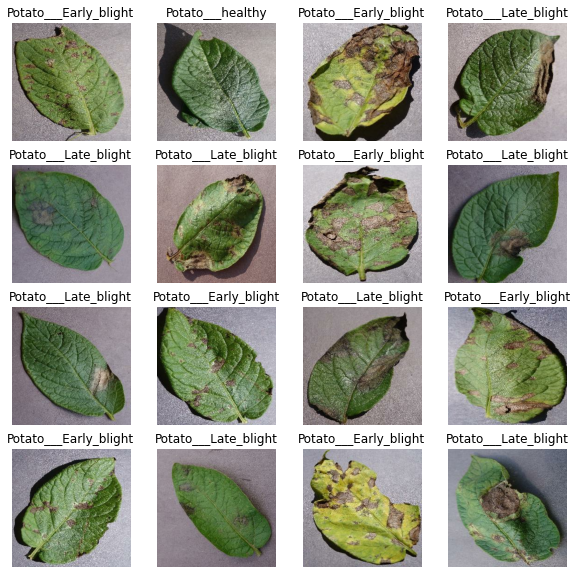

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])    
        plt.axis('off')

In [9]:
DATASET_SIZE = len(data)

In [10]:
def partition_dataset( dataset, train_split= 0.8, test_split= 0.1, shuffle= True, shuffle_size= 10000):
    train_size = int(0.8 * len(dataset))
    val_size = int(0.10 * len(dataset))
    test_size = int(0.10 * len(dataset))
    
    if shuffle: 
        dataset = dataset.shuffle(shuffle_size, seed= 12)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = partition_dataset(data)

In [12]:
print("Train size:",len(train_dataset),
      "\nValidation size:", len(val_dataset),
      "\nTest size:", len(test_dataset))

Train size: 54 
Validation size: 6 
Test size: 8


In [13]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [14]:
resizing_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(*IMGSIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
model = models.Sequential([
    resizing_rescaling,
    data_augmentation,
    
    layers.Conv2D(32,(3,3), activation= "relu", input_shape = (BATCHSIZE,*IMGSIZE, 3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(len(class_names), activation= "softmax")
    
])

In [17]:
model.build(input_shape = (BATCHSIZE,*IMGSIZE, 3))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer= "adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [ ]:
hist = model.fit(
    train_dataset,
    epochs= 10,
    batch_size= BATCHSIZE,
    verbose= 1,
    validation_data= val_dataset
)

Epoch 1/10


In [ ]:
model.evaluate(test_dataset)

In [ ]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in data.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        actual= class_names[label_batch[i]]
        predict= class_names[np.argmax(model.predict(image_batch)[i])]
        plt.title(f"Correct label: {actual} \nPredicted label: {predict} \nPrediction confidence {round(100*np.max(model.predict(image_batch)[i]),2)}%")